### Figure 6 | Circulating immune-cell composition remains largely unchanged following vaccination
Inferred PBMC subset proportions across timepoints indicate minimal compositional shifts despite transcriptional remodeling.

SARC_DATA_ROOT was not set; using: /mnt/z

Using join key: sample_id (match sample_id=1, match rn_sample_id=0)

Warning message:
“`geom_errorbarh()` was deprecated in ggplot2 4.0.0.
ℹ Please use the `orientation` argument of `geom_errorbar()` instead.”
`height` was translated to `width`.
`height` was translated to `width`.
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for 'SARC − HC (mean % difference)' in 'mbcsToSbcs': - substituted for − (U+2212)”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for 'q ≤ 0.05' in 'mbcsToSbcs': <= substituted for ≤ (U+2264)”
`height` was translated to `width`.


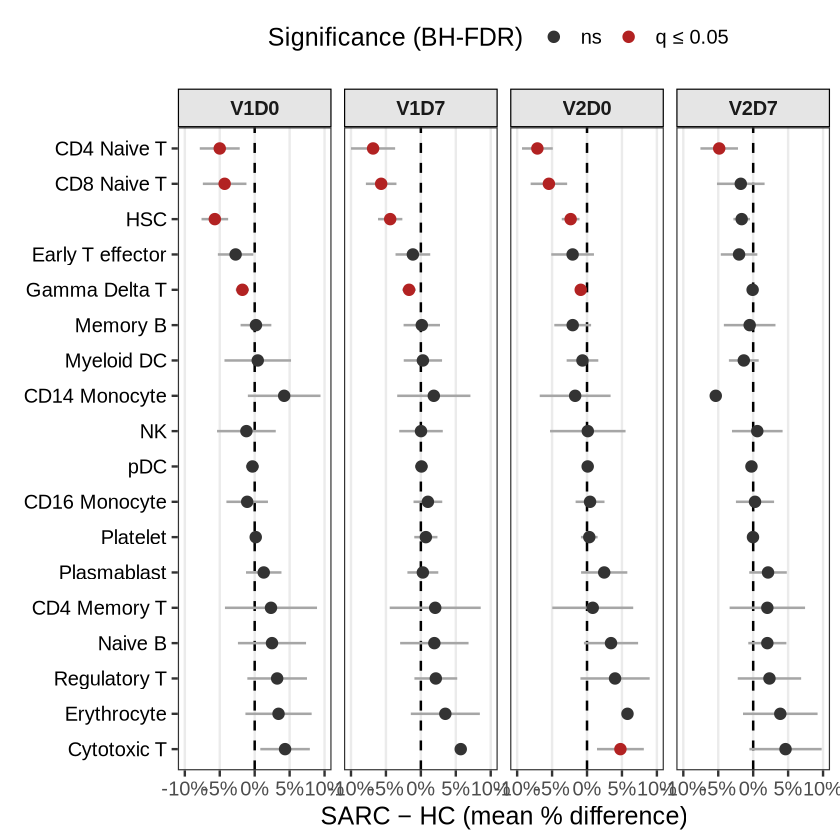

In [1]:
# =============================
# CIBERSORTx forest plot (SARC − HC) across timepoints
# No cell-type merging
# Significance encoded by COLOR (not shape)
# Grey 95% CI lines
# Robust to Bioconductor select() masking and duplicated sample_id
# =============================

suppressPackageStartupMessages({
  library(SummarizedExperiment)
  library(dplyr)
  library(tidyr)
  library(readr)
  library(stringr)
  library(ggplot2)
  library(tibble)
})


## --------------------------
## 0) Setup and load paired cohort
## --------------------------
# Parallel setup
if (.Platform$OS.type == "windows") {
  BiocParallel::register(
    BiocParallel::SnowParam(workers = max(1, parallel::detectCores() - 1))
  )
} else {
  BiocParallel::register(
    BiocParallel::MulticoreParam(workers = max(1, parallel::detectCores() - 1))
  )
}
set.seed(42)

SCRIPT_REL_PATH <- NULL

if (is.null(SCRIPT_REL_PATH)) {
  # Interactive / notebook fallback: do not error, but warn if here() looks wrong
  if (!file.exists(here::here("README.md")) && !dir.exists(here::here(".git"))) {
    warning(
      "Repo root not detected via here(). ",
      "If paths are wrong, set your working directory to the repo root OR set SCRIPT_REL_PATH."
    )
  }
} else {
  here::i_am(SCRIPT_REL_PATH)
}

# ----------------------------
# Inputs
# ----------------------------
DATA_ROOT <- Sys.getenv("SARC_DATA_ROOT")

DATA_DIR <- here::here("data", "derived")
dir.create(DATA_DIR, recursive = TRUE, showWarnings = FALSE)

TAB_DIR <- here::here("tables", "main")
dir.create(TAB_DIR, recursive = TRUE, showWarnings = FALSE)

FIG_DIR <- here::here("figures", "main")
dir.create(FIG_DIR, recursive = TRUE, showWarnings = FALSE)

if (DATA_ROOT == "") {
  # sensible default for your setup; change if needed
  DATA_ROOT <- "/mnt/z"
  Sys.setenv(SARC_DATA_ROOT = DATA_ROOT)
  message("SARC_DATA_ROOT was not set; using: ", DATA_ROOT)
}

# NOTE USES THE PAIRED ALL TIMEPOINTS SE FOR CONSISTENCY
if (!dir.exists(DATA_ROOT)) stop(glue("DATA_ROOT not found: {DATA_ROOT}"), call. = FALSE)
SE_RDS <- file.path(DATA_ROOT, "se_paired_all_timepoints.rds")
if (!file.exists(SE_RDS)) stop(glue("Missing input file: {SE_RDS}"), call. = FALSE)
se_all_full <- readRDS(SE_RDS)

stopifnot(exists("se_all_full"), is(se_all_full, "SummarizedExperiment"))

se <- se_all_full  # change if needed

# Prefer the uploaded path if it exists; otherwise use your /mnt/z path.
results_path_candidates <- file.path(DATA_DIR, "CIBERSORTx_Job47_Results_sarcoidosis_reference.csv")
results_path <- results_path_candidates[file.exists(results_path_candidates)][1]
stopifnot(!is.na(results_path), file.exists(results_path))

out_png <- file.path(FIG_DIR, "Fig6_cibersortx_forestplot_SARC_minus_HC_sigColor.png")
out_pdf <- file.path(FIG_DIR, "Fig6_cibersortx_forestplot_SARC_minus_HC_sigColor.pdf")

# Color choices (journal-safe; not overly bright)
COL_SIG <- "#B22222"  # dark red
COL_NS  <- "grey20"   # dark grey
COL_CI  <- "grey65"   # CI line grey

# -----------------------------
# 1) Build metadata (safe join key)
# -----------------------------
cd <- as.data.frame(SummarizedExperiment::colData(se))
cd <- tibble::as_tibble(cd, .name_repair = "unique") %>%
  tibble::rownames_to_column("rn_sample_id")

if (!("sample_id" %in% names(cd))) {
  cd <- cd %>% dplyr::mutate(sample_id = rn_sample_id)
}

meta0 <- cd %>%
  dplyr::mutate(
    rn_sample_id = as.character(rn_sample_id),
    sample_id    = as.character(sample_id),
    disease      = as.character(.data$disease),
    time_point   = as.character(.data$time_point),
    participant  = as.character(.data$participant)
  ) %>%
  dplyr::select(rn_sample_id, sample_id, disease, time_point, participant) %>%
  dplyr::mutate(
    disease = dplyr::case_when(
      disease %in% c("SX","SARC","Sarcoidosis") ~ "SARC",
      disease %in% c("HC","Control") ~ "HC",
      TRUE ~ disease
    )
  )

# -----------------------------
# 2) Read CIBERSORTx results
# -----------------------------
cbx <- readr::read_csv(results_path, show_col_types = FALSE)
stopifnot("Mixture" %in% colnames(cbx))

diag_cols <- intersect(colnames(cbx), c("P-value", "Correlation", "RMSE"))
frac_cols <- setdiff(colnames(cbx), c("Mixture", diag_cols))
stopifnot(length(frac_cols) > 0)

mixtures <- as.character(cbx$Mixture)

# choose join key: whichever matches cbx$Mixture better (sample_id vs rn_sample_id)
match_sample_id <- mean(mixtures %in% meta0$sample_id)
match_rn_id     <- mean(mixtures %in% meta0$rn_sample_id)
join_key <- if (match_rn_id > match_sample_id) "rn_sample_id" else "sample_id"

message("Using join key: ", join_key,
        " (match sample_id=", round(match_sample_id, 3),
        ", match rn_sample_id=", round(match_rn_id, 3), ")")

meta <- meta0 %>%
  dplyr::transmute(
    sample_id = .data[[join_key]],
    disease, time_point, participant
  )

# -----------------------------
# 3) Long format (fractions per sample x cell type)
# -----------------------------
long0 <- cbx %>%
  dplyr::rename(sample_id = Mixture) %>%
  dplyr::select(sample_id, dplyr::all_of(frac_cols)) %>%
  tidyr::pivot_longer(
    cols = dplyr::all_of(frac_cols),
    names_to = "cell_type",
    values_to = "fraction"
  ) %>%
  dplyr::mutate(
    sample_id = as.character(sample_id),
    cell_type = as.character(cell_type),
    fraction  = as.numeric(fraction)
  ) %>%
  dplyr::left_join(meta, by = "sample_id")

missing_meta <- long0 %>%
  dplyr::filter(is.na(disease) | is.na(time_point)) %>%
  dplyr::distinct(sample_id)

if (nrow(missing_meta) > 0) {
  message("WARNING: Some CIBERSORTx mixtures did not match se@colData. Example(s): ",
          paste(head(missing_meta$sample_id, 8), collapse = ", "))
}

# restrict to intended groups/timepoints
long <- long0 %>%
  dplyr::filter(
    !is.na(disease), disease %in% c("HC","SARC"),
    !is.na(time_point), time_point %in% c("V1D0","V1D7","V2D0","V2D7")
  ) %>%
  dplyr::select(sample_id, disease, time_point, participant, cell_type, fraction)

# -----------------------------
# 4) Compute SARC − HC mean difference with 95% CI per timepoint + cell_type
# -----------------------------
summ <- long %>%
  dplyr::group_by(time_point, cell_type, disease) %>%
  dplyr::summarise(
    n    = sum(!is.na(fraction)),
    mean = mean(fraction, na.rm = TRUE),
    var  = var(fraction, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  tidyr::pivot_wider(names_from = disease, values_from = c(n, mean, var))

summ <- summ %>%
  dplyr::filter(!is.na(n_HC), !is.na(n_SARC))

# Welch-style CI for difference in means
stats_df <- summ %>%
  dplyr::mutate(
    diff = mean_SARC - mean_HC,
    se   = sqrt((var_SARC / n_SARC) + (var_HC / n_HC)),
    df   = ((var_SARC/n_SARC + var_HC/n_HC)^2) /
      ((var_SARC^2)/((n_SARC^2) * pmax(n_SARC - 1, 1)) + (var_HC^2)/((n_HC^2) * pmax(n_HC - 1, 1))),
    tcrit = stats::qt(0.975, df = df),
    lo = diff - tcrit * se,
    hi = diff + tcrit * se
  )

# Per-timepoint p-values (Welch t-test) + BH-FDR
pvals <- long %>%
  dplyr::group_by(time_point, cell_type) %>%
  dplyr::summarise(
    p = tryCatch(stats::t.test(fraction ~ disease)$p.value, error = function(e) NA_real_),
    .groups = "drop"
  ) %>%
  dplyr::group_by(time_point) %>%
  dplyr::mutate(q = stats::p.adjust(p, method = "BH")) %>%
  dplyr::ungroup()

plot_df <- stats_df %>%
  dplyr::left_join(pvals, by = c("time_point","cell_type")) %>%
  dplyr::mutate(
    diff_pct = 100 * diff,
    lo_pct   = 100 * lo,
    hi_pct   = 100 * hi,
    sig      = dplyr::if_else(!is.na(q) & q <= 0.05, "q ≤ 0.05", "ns")
  )

# Keep your cell type order stable across facets (alphabetical by default).
# If you have a preferred custom order, replace the levels below.
# plot_df <- plot_df %>%
#   dplyr::mutate(
#     cell_type = factor(cell_type, levels = rev(sort(unique(as.character(cell_type))))),
#     time_point = factor(time_point, levels = c("V1D0","V1D7","V2D0","V2D7")),
#     sig = factor(sig, levels = c("ns", "q ≤ 0.05"))
#   )

# Order cell types by mean percent difference (SARC−HC) across timepoints
cell_order <- plot_df %>%
  dplyr::group_by(cell_type) %>%
  dplyr::summarise(mean_diff_pct = mean(diff_pct, na.rm = TRUE), .groups = "drop") %>%
  dplyr::arrange(mean_diff_pct) %>%           # ascending; use desc() for descending
  dplyr::pull(cell_type) %>%
  as.character()

plot_df <- plot_df %>%
  dplyr::mutate(
    cell_type  = factor(cell_type, levels = rev(cell_order)), # rev() puts largest at top
    time_point = factor(time_point, levels = c("V1D0","V1D7","V2D0","V2D7")),
    sig        = factor(sig, levels = c("ns", "q ≤ 0.05"))
  )


# -----------------------------
# 5) Plot (forest plot faceted by timepoint)
# -----------------------------
p <- ggplot(plot_df, aes(x = diff_pct, y = cell_type)) +
  geom_vline(xintercept = 0, linetype = "dashed", linewidth = 0.7) +
  geom_errorbarh(
    aes(xmin = lo_pct, xmax = hi_pct),
    height = 0,
    color = COL_CI,
    linewidth = 0.7
  ) +
  geom_point(
    aes(color = sig),
    size = 2.6
  ) +
  facet_wrap(~ time_point, nrow = 1) +
  scale_color_manual(
    values = c("ns" = COL_NS, "q ≤ 0.05" = COL_SIG),
    name = "Significance (BH-FDR)"
  ) +
  scale_x_continuous(
    limits = c(-10, 10),
    breaks = seq(-10, 10, 5),
    labels = function(x) paste0(x, "%")
  ) +
  scale_y_discrete(
    labels = function(x) gsub("_", " ", x)
  ) +
  labs(
    x = "SARC − HC (mean % difference)",
    y = NULL
  ) +
  theme_bw(base_size = 15) +
  theme(
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_rect(fill = "grey90", color = "black"),
    strip.text = element_text(face = "bold"),
    legend.position = "top",
    axis.text.y = element_text(size = 12, color = "black"),
    plot.margin = margin(6, 6, 6, 14)
  )
# -----------------------------

ggsave(out_png, p, width = 12, height = 6, dpi = 300)
ggsave(out_pdf, p, width = 12, height = 6)

p
